<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment2/MachineLearningAssignment2SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading libraries and Data in

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

In [2]:
from google.colab import files
uploaded = files.upload()
data = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', sep='\t', delimiter=None, header='infer', names=None, index_col=None)

Saving Sentiment140.tenPercent.sample.tweets.tsv to Sentiment140.tenPercent.sample.tweets.tsv


# Data Exploration

Check Size of Data

In [3]:
print(data.head())
print(data.info())

   sentiment_label  \
0                4   
1                4   
2                0   
3                0   
4                0   

                                                                                                               tweet_text  
0                                   @elephantbird Hey dear, Happy Friday to You  Already had your rice's bowl for lunch ?  
1                                                              Ughhh layin downnnn    Waiting for zeina to cook breakfast  
2    @greeniebach I reckon he'll play, even if he's not 100%...but i know nothing!! ;) It won't be the same without him.   
3                                                                                   @vaLewee I know!  Saw it on the news!  
4  very sad that http://www.fabchannel.com/ has closed down. One of the few web services that I've used for over 5 years   
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column  

Check if any missing values

In [4]:
print(data.isnull().values.any())

False


In [5]:
df = data.copy()
df.rename(columns = {'sentiment_label':'target'}, inplace = True)

print("Number of duplicates before dropping:  " + str(len(df[df.duplicated()])))

df.drop_duplicates(keep = False, inplace = True)
print("Number of duplicates after dropping:  " + str(len(df[df.duplicated()])))

Number of duplicates before dropping:  553
Number of duplicates after dropping:  0


Checking if data balanced

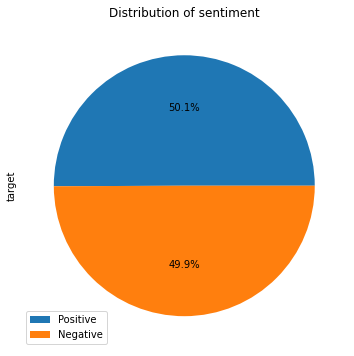

In [6]:
df['target'] = df['target'].replace(4,1)

df['target'].value_counts().plot.pie(figsize=(6,6),title="Distribution of sentiment",labels=['',''],autopct='%1.1f%%')
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

Creating word clouds...


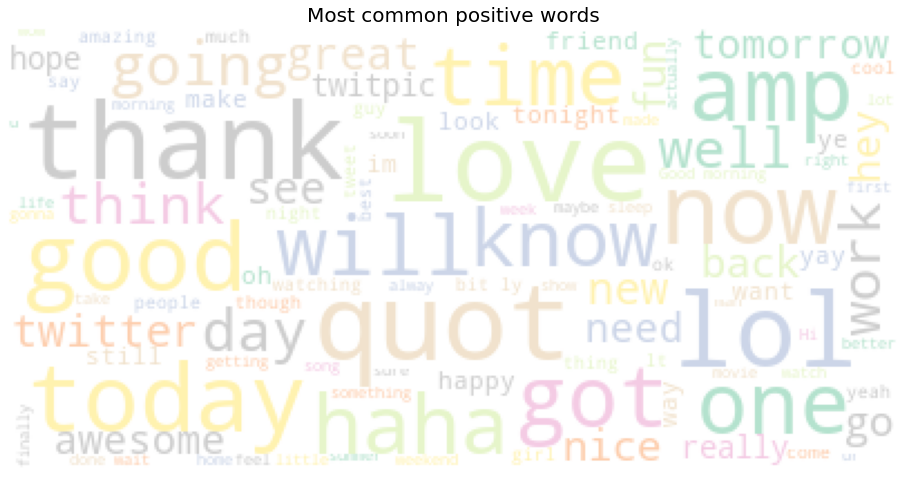

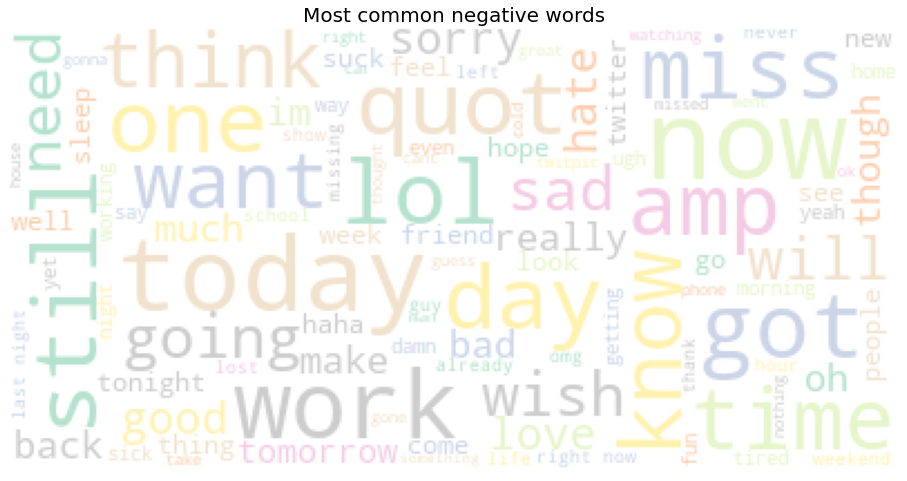

In [7]:
from wordcloud import WordCloud
from collections import Counter

def generate_wordcloud(words,sentiment):
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("Most common {} words".format(sentiment), fontsize=20)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=17), alpha=0.98)
    plt.axis('off')

print("Creating word clouds...")
positive_words=" ".join(df[df.target==1]['tweet_text'].values)
negative_words=" ".join(df[df.target==0]['tweet_text'].values)

generate_wordcloud(positive_words,"positive")
generate_wordcloud(negative_words,"negative")


# Data Pre-processing

In [130]:
dataset = df.copy()

In [131]:
dataset['tweet_text']=dataset['tweet_text'].str.lower()
print(dataset['tweet_text'].head(30))

0                                                                    @elephantbird hey dear, happy friday to you  already had your rice's bowl for lunch ?
1                                                                                               ughhh layin downnnn    waiting for zeina to cook breakfast
2                                     @greeniebach i reckon he'll play, even if he's not 100%...but i know nothing!! ;) it won't be the same without him. 
3                                                                                                                    @valewee i know!  saw it on the news!
4                                   very sad that http://www.fabchannel.com/ has closed down. one of the few web services that i've used for over 5 years 
5                                                          @fearnecotton who sings 'i remember'? i alwaysss hear it on radio 1 but never catch the artist 
6                                                                     

In [136]:
new_stop_words = ['a', 'about',  'am', 'an','got','going', 'now','know','look','day','back','one','hey',"he'll",'ur',"i've",'u','im','&quot;','go',"he's","him",
                  'seein','saw',"i'm","y'all",'lol']
        # 'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
        #      'being', 'between','both', 'by', 'd', 'did', 'do',
        #      'does', 'doing', 'during', 'each', 'for', 'from',
        #      'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
        #      'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
        #      'into','is', 'it', 'im' 'its', 'itself', 'just', 'll', 'm', 'ma',
        #      'me','my', 'myself', 'now', 'o', 'of', 'on', 'once',
        #      'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes",'so', 'some', 'such',
        #      't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
        #      'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
        #      'through', 'to', 'too', 'up', 've', 'was',
        #      'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom', 'will', 'with', 'y', 'you', "youd","youll", "youre",
        #      "youve", 'your', 'yours', 'yourself', 'yourselves'

In [138]:
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(new_stop_words)

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda text: cleaning_stopwords(text))
print(dataset['tweet_text'].head(50))

0                                             @elephantbird dear, happy friday already rice's bowl lunch ?
1                                                         ughhh layin downnnn waiting zeina cook breakfast
2                                      @greeniebach reckon play, even 100%...but nothing!! ;) without him.
3                                                                                     @valewee know! news!
4                                    sad http://www.fabchannel.com/ closed down. web services used 5 years
5                               @fearnecotton sings 'i remember'? alwaysss hear radio 1 never catch artist
6                                                                           god side anything possible....
7                                                                                        @lovesmrs stupid?
8                                delved guts expression engine, flexible cms use dev, great clients though
9                                    

Replace twitter handles with @thisisauser

In [139]:
def remove_handles(text):
    return re.sub("@[A-Za-z0-9]+", r'', text)
dataset['tweet_text']= dataset['tweet_text'].apply(lambda x: remove_handles(x))
print(dataset['tweet_text'].head(10))

0                               dear, happy friday already rice's bowl lunch ?
1                             ughhh layin downnnn waiting zeina cook breakfast
2                       reckon play, even 100%...but nothing!! ;) without him.
3                                                                  know! news!
4        sad http://www.fabchannel.com/ closed down. web services used 5 years
5                 sings 'i remember'? alwaysss hear radio 1 never catch artist
6                                               god side anything possible....
7                                                                      stupid?
8    delved guts expression engine, flexible cms use dev, great clients though
9                                                               awww take you!
Name: tweet_text, dtype: object


In [140]:
def cleaning_URLs(data):
    return re.sub('http\S+|www.\S+',' ',data)
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda x: cleaning_URLs(x))
print(dataset['tweet_text'].head(30))

0                                                  dear, happy friday already rice's bowl lunch ?
1                                                ughhh layin downnnn waiting zeina cook breakfast
2                                          reckon play, even 100%...but nothing!! ;) without him.
3                                                                                     know! news!
4                                                    sad   closed down. web services used 5 years
5                                    sings 'i remember'? alwaysss hear radio 1 never catch artist
6                                                                  god side anything possible....
7                                                                                         stupid?
8                       delved guts expression engine, flexible cms use dev, great clients though
9                                                                                         a  you!
10                  

In [141]:
def cleaning_punctuations(data):
    return re.sub('[,.;@#?!%-&)$]+\ *',' ',data)
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda x: cleaning_punctuations(x))

print(dataset['tweet_text'].head(30))

0                                                 dear happy friday already rice's bowl lunch  
1                                              ughhh layin downnnn waiting zeina cook breakfast
2                                                reckon play even 100 but nothing  without him 
3                                                                                    know news 
4                                                   sad   closed down web services used 5 years
5                                   sings 'i remember' alwaysss hear radio 1 never catch artist
6                                                                   god side anything possible 
7                                                                                       stupid 
8                       delved guts expression engine flexible cms use dev great clients though
9                                                                                       a  you 
10                                      

In [142]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda x: cleaning_numbers(x))
print(dataset['tweet_text'].head(30))

0                                                 dear happy friday already rice's bowl lunch  
1                                              ughhh layin downnnn waiting zeina cook breakfast
2                                                   reckon play even  but nothing  without him 
3                                                                                    know news 
4                                                    sad   closed down web services used  years
5                                    sings 'i remember' alwaysss hear radio  never catch artist
6                                                                   god side anything possible 
7                                                                                       stupid 
8                       delved guts expression engine flexible cms use dev great clients though
9                                                                                       a  you 
10                                      

In [143]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize 

dataset['tweet_text'] = dataset['tweet_text'].apply(word_tokenize)
print(dataset['tweet_text'].head(30))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
0                                                     [dear, happy, friday, already, rice, 's, bowl, lunch]
1                                                  [ughhh, layin, downnnn, waiting, zeina, cook, breakfast]
2                                                          [reckon, play, even, but, nothing, without, him]
3                                                                                              [know, news]
4                                                           [sad, closed, down, web, services, used, years]
5                                     [sings, 'i, remember, ', alwaysss, hear, radio, never, catch, artist]
6                                                                           [god, side, anything, possible]
7                                                                                                  [stupid]
8                       [

In [144]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['tweet_text']= dataset['tweet_text'].apply(lambda x: stemming_on_text(x))
print(dataset['tweet_text'].head(30))

0                                                     [dear, happy, friday, already, rice, 's, bowl, lunch]
1                                                  [ughhh, layin, downnnn, waiting, zeina, cook, breakfast]
2                                                          [reckon, play, even, but, nothing, without, him]
3                                                                                              [know, news]
4                                                           [sad, closed, down, web, services, used, years]
5                                     [sings, 'i, remember, ', alwaysss, hear, radio, never, catch, artist]
6                                                                           [god, side, anything, possible]
7                                                                                                  [stupid]
8                       [delved, guts, expression, engine, flexible, cms, use, dev, great, clients, though]
9                           

In [118]:
import nltk
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda x: lemmatizer_on_text(x))
print(dataset['tweet_text'].head(10))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
0                             [hey, dear, happy, friday, already, rice, 's, bowl, lunch]
1                               [ughhh, layin, downnnn, waiting, zeina, cook, breakfast]
2                                [reckon, he, 'll, play, even, he, 's, nothing, without]
3                                                                            [saw, news]
4                                 [sad, closed, one, web, services, i, 've, used, years]
5                  [sings, 'i, remember, ', alwaysss, hear, radio, never, catch, artist]
6                                                    [god, ur, side, anything, possible]
7                                                                               [stupid]
8    [delved, guts, expression, engine, flexible, cms, use, dev, great, clients, though]
9                                                                           [awww, t

Untokenise so can vectorise (expects string)

In [119]:
import re
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok
detokenizer = Detok()

dataset['tweet_text_untokenised'] = dataset.tweet_text.apply(lambda row: detokenizer.detokenize(row))
print(dataset['tweet_text_untokenised'].head(30))

0                                       hey dear happy friday already rice's bowl lunch
1                                      ughhh layin downnnn waiting zeina cook breakfast
2                                           reckon he'll play even he's nothing without
3                                                                              saw news
4                                           sad closed one web services i've used years
5                             sings 'i remember' alwaysss hear radio never catch artist
6                                                         god ur side anything possible
7                                                                                stupid
8               delved guts expression engine flexible cms use dev great clients though
9                                                                             awww take
10                                                      video vh much better u tube one
11                        ran ch

In [ ]:
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(new_stop_words)

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['tweet_text_untokenised'] = dataset['tweet_text_untokenised'].apply(lambda text: cleaning_stopwords(text))
print(dataset['tweet_text_untokenised'].head(50))

Creating word clouds...


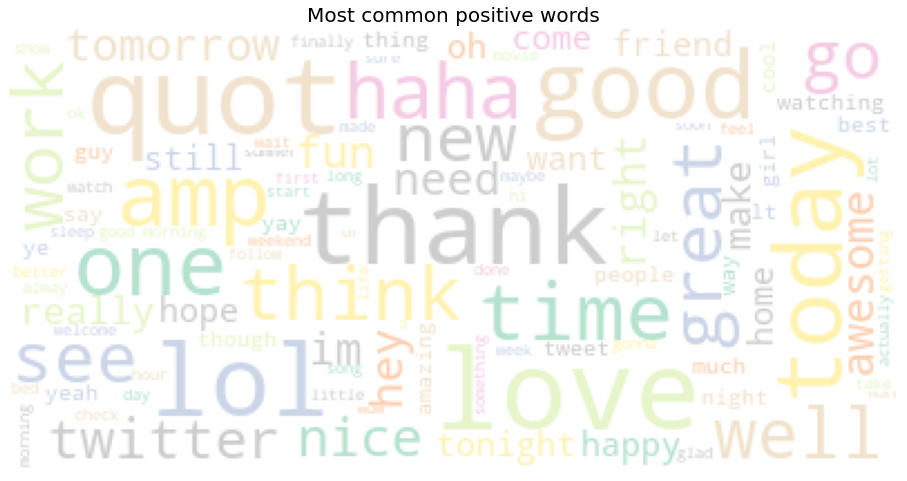

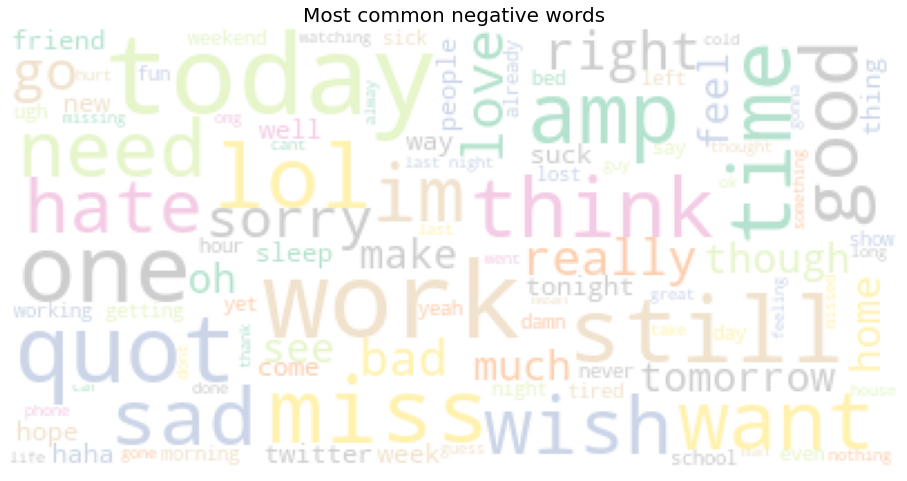

In [120]:
print("Creating word clouds...")
positive_words=" ".join(dataset[dataset.target==1]['tweet_text_untokenised'].values)
negative_words=" ".join(dataset[dataset.target==0]['tweet_text_untokenised'].values)

generate_wordcloud(positive_words,"positive")
generate_wordcloud(negative_words,"negative")

# Machine Learning

In [121]:
X=dataset.tweet_text_untokenised
y=dataset.target

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state =0)

Turn Sentences into numerica data

In [123]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=700000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  634353


In [124]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [125]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['BernoulliNB'] = BernoulliNB()
models['Support Vector Machines'] = LinearSVC()
models['Logistic Regression'] = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)

In [126]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall, predictions = {}, {}, {}, {}

for key in models.keys():
    
    # Fit the classifier model
    models[key].fit(X_train, y_train)
    # Prediction 
    predictions[key] = models[key].predict(X_test)
    
    # Calculate Accuracy, Precision and Recall Metrics
    accuracy[key] = accuracy_score(predictions[key], y_test)
    precision[key] = precision_score(predictions[key], y_test)
    recall[key] = recall_score(predictions[key], y_test)

# Evaluation

Show Accuracy, Precision & Recall

                         Accuracy  Precision    Recall
BernoulliNB              0.759331   0.794539  0.744944
Support Vector Machines  0.768443   0.766114  0.772567
Logistic Regression      0.776172   0.779205  0.777267


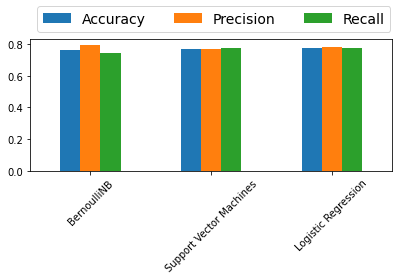

In [127]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

print(df_model)

ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 14})
plt.tight_layout()

Plot Correlation Matrices

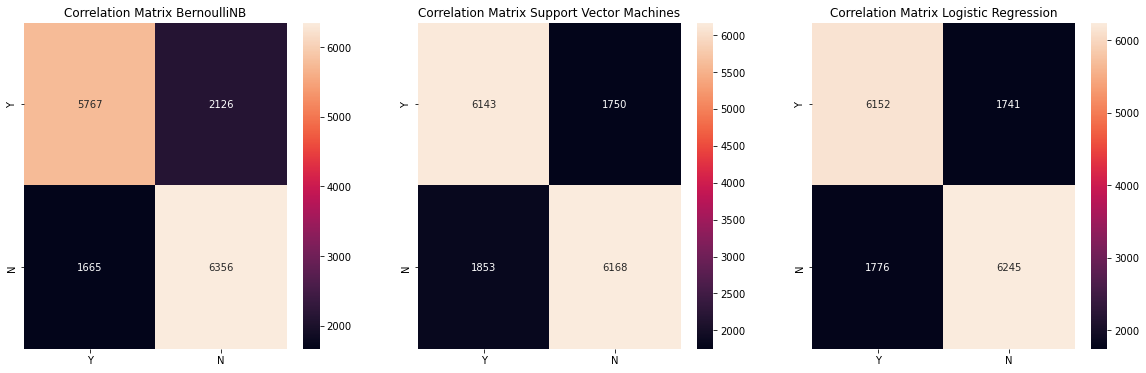

In [98]:
from sklearn.metrics import confusion_matrix

def get_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  return cm

def plot_cm(ax,labels, predictions,title, p=0.5):
  tick_labels = ['Y', 'N']
  cm = get_cm(labels, predictions, p)
  sns.heatmap(cm, annot=True, fmt="d",ax=ax)
  ax.title.set_text(title)
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))
plot_cm(ax1,y_test, predictions['BernoulliNB'],"Correlation Matrix BernoulliNB")
plot_cm(ax2,y_test, predictions['Support Vector Machines'],"Correlation Matrix Support Vector Machines")
plot_cm(ax3,y_test, predictions['Logistic Regression'],"Correlation Matrix Logistic Regression")

Plot ROC Curves

In [99]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(ax,labels, predictions,title):
  fpr, tpr, thresholds = roc_curve(labels, predictions)
  roc_auc = auc(fpr, tpr)
  ax.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.legend(loc="lower right")
  ax.title.set_text(title)

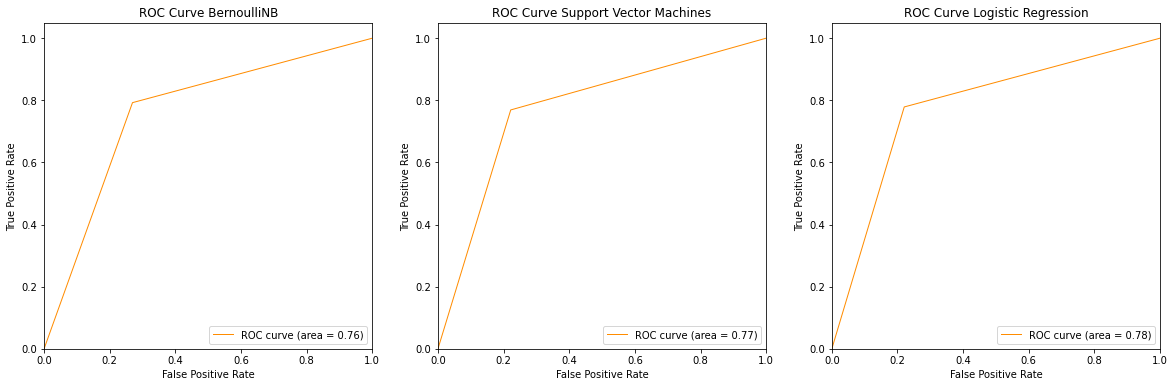

In [100]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))
plot_roc_curve(ax1, y_test, predictions['BernoulliNB'],"ROC Curve BernoulliNB")
plot_roc_curve(ax2, y_test, predictions['Support Vector Machines'],"ROC Curve Support Vector Machines")
plot_roc_curve(ax3, y_test, predictions['Logistic Regression'],"ROC Curve Logistic Regression")